### 두 가지 회귀 모델(SVR과 KRR)의 성능을 비교하고, 최적의 하이퍼파라미터 탐색, 모델 학습 및 예측 시간 측정, 서포트 벡터의 비율 계산, 그리고 학습 곡선을 통한 학습 과정 시각화

In [1]:
import numpy as np

rng = np.random.RandomState(42)

X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

y[::5] += 3 * (0.5 - rng.rand(X.shape[0] // 5))

X_plot = np.linspace(0, 5, 100000)[:, None]

In [2]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

train_size = 100
# SVR과 KRR 모델을 각각 그리드 서치와 함께 설정합니다. C, gamma, alpha 등의 하이퍼파라미터에 대한 후보 값을 지정합니다.
svr = GridSearchCV(
    SVR(kernel="rbf", gamma=0.1),
    param_grid={"C": [1e0, 1e1, 1e2, 1e3], "gamma": np.logspace(-2, 2, 5)},
)

kr = GridSearchCV(
    KernelRidge(kernel="rbf", gamma=0.1),
    param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3], "gamma": np.logspace(-2, 2, 5)},
)

In [3]:
import time

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print(f"Best SVR with params: {svr.best_params_} and R2 score: {svr.best_score_:.3f}")
print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print(f"Best KRR with params: {kr.best_params_} and R2 score: {kr.best_score_:.3f}")
print("KRR complexity and bandwidth selected and model fitted in %.3f s" % kr_fit)

sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s" % (X_plot.shape[0], svr_predict))

t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s" % (X_plot.shape[0], kr_predict))

Best SVR with params: {'C': 1.0, 'gamma': 0.1} and R2 score: 0.737
SVR complexity and bandwidth selected and model fitted in 0.366 s
Best KRR with params: {'alpha': 0.1, 'gamma': 0.1} and R2 score: 0.723
KRR complexity and bandwidth selected and model fitted in 0.999 s
Support vector ratio: 0.340
SVR prediction for 100000 inputs in 0.128 s
KRR prediction for 100000 inputs in 0.115 s


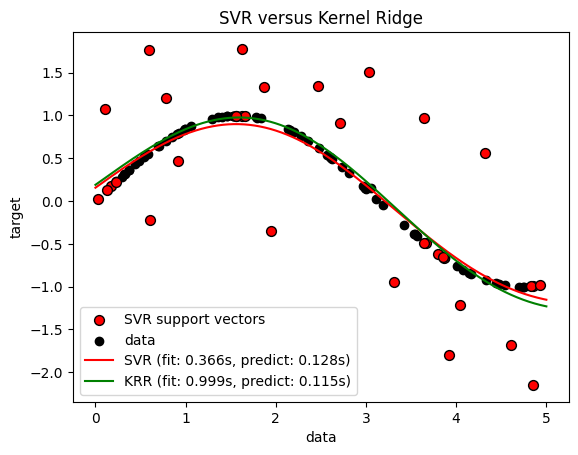

In [4]:
import matplotlib.pyplot as plt

sv_ind = svr.best_estimator_.support_
plt.scatter(
    X[sv_ind],
    y[sv_ind],
    c="r",
    s=50,
    label="SVR support vectors",
    zorder=2,
    edgecolors=(0, 0, 0),
)
plt.scatter(X[:100], y[:100], c="k", label="data", zorder=1, edgecolors=(0, 0, 0))
plt.plot(
    X_plot,
    y_svr,
    c="r",
    label="SVR (fit: %.3fs, predict: %.3fs)" % (svr_fit, svr_predict),
)
plt.plot(
    X_plot, y_kr, c="g", label="KRR (fit: %.3fs, predict: %.3fs)" % (kr_fit, kr_predict)
)
plt.xlabel("data")
plt.ylabel("target")
plt.title("SVR versus Kernel Ridge")
_ = plt.legend()

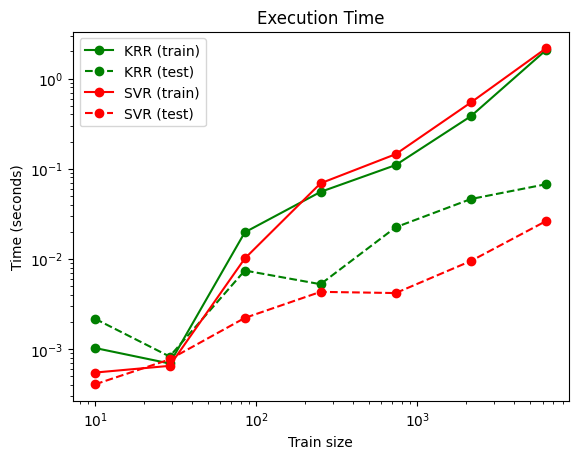

In [5]:
plt.figure()
# 학습 시간과 테스트 시간을 다양한 훈련 데이터 크기에 대해 측정하고, 그 결과를 시각화합니다.
sizes = np.logspace(1, 3.8, 7).astype(int)
for name, estimator in {
    "KRR": KernelRidge(kernel="rbf", alpha=0.01, gamma=10),
    "SVR": SVR(kernel="rbf", C=1e2, gamma=10),
}.items():
    train_time = []
    test_time = []
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(
        sizes,
        train_time,
        "o-",
        color="r" if name == "SVR" else "g",
        label="%s (train)" % name,
    )
    plt.plot(
        sizes,
        test_time,
        "o--",
        color="r" if name == "SVR" else "g",
        label="%s (test)" % name,
    )

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title("Execution Time")
_ = plt.legend(loc="best")

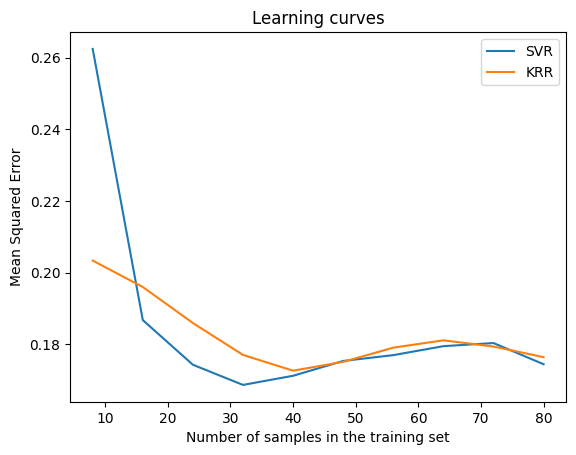

In [6]:
from sklearn.model_selection import LearningCurveDisplay

_, ax = plt.subplots()

svr = SVR(kernel="rbf", C=1e1, gamma=0.1)
kr = KernelRidge(kernel="rbf", alpha=0.1, gamma=0.1)

common_params = {
    "X": X[:100],
    "y": y[:100],
    "train_sizes": np.linspace(0.1, 1, 10),
    "scoring": "neg_mean_squared_error",
    "negate_score": True,
    "score_name": "Mean Squared Error",
    "score_type": "test",
    "std_display_style": None,
    "ax": ax,
}

LearningCurveDisplay.from_estimator(svr, **common_params)
LearningCurveDisplay.from_estimator(kr, **common_params)
ax.set_title("Learning curves")
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=["SVR", "KRR"])

plt.show()